# Tracking a Lorenz particle

## Theoretical Questions 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from numpy import pi
import random
import matplotlib.animation as animation
from matplotlib.widgets import Slider
from scipy.stats import entropy, wasserstein_distance
from ipywidgets import interact, FloatSlider



## Empirical probability density function 

a)

In [2]:

sigma = 10.0
rho = 28.0
beta = 8.0/3.0

# Lorenz model

def Lorenz(state,t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0] # initial condition
t = np.arange(0.0, 100.0, 0.02) # time vector

states = odeint(Lorenz, state0, t) # vector containing the (x,y,z) positions for each time step


def is_in_box(x, y, z, box):
    """
    Check if the point (x, y, z) is inside the box.
    """
    x0, x1 = box[0][0] , box[0][1]
    y0, y1 = box[1][0] , box[1][1]
    z0, z1 = box[2][0] , box[2][1]
   
    return (x0 <= x <= x1) and (y0 <= y <= y1) and (z0 <= z <= z1)
    
def create_box(domain , box_length):
    """
    Create boxes in the domain with the given box length.
    """
    boxes = {}
    x0 = domain[0][0] 
    x1 = domain[0][0]
    y0 = domain[1][0]
    y1 = domain[1][0] 
    z0 = domain[2][0] 
    z1 = domain[2][0] 
    for i in range((domain[0][1] - domain[0][0])//box_length):
        for j in range((domain[1][1] - domain[1][0])//box_length):
            for k in range((domain[2][1] - domain[2][0])//box_length):
                x0 = domain[0][0] + i * box_length
                x1 = x0 + box_length
                y0 = domain[1][0] + j * box_length
                y1 = y0 + box_length
                z0 = domain[2][0] + k * box_length
                z1 = z0 + box_length

                # Initialiser la boîte avec un compteur à 0
                boxes[((x0, x1), (y0, y1), (z0, z1))] = 0
    return boxes


def plot_3d_scatter(boxes):
    """
    Affiche un nuage de points 3D où la couleur indique la densité.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    x_vals = []
    y_vals = []
    z_vals = []
    density = []
    boxes = {k: v for k, v in boxes.items() if v > 0}

    for ((x0, x1), (y0, y1), (z0, z1)), count in boxes.items():
        x_vals.append((x0 + x1) / 2)  # Position au centre de la boîte
        y_vals.append((y0 + y1) / 2)
        z_vals.append((z0 + z1) / 2)
        density.append(count)

    sc = ax.scatter(x_vals, y_vals, z_vals, c=density, cmap='plasma', s=30)
    plt.colorbar(sc, label="Nombre de points")
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Distribution des points en 3D")
    
    plt.show()

def plot_2d_heatmaps(boxes, box_length):
    """
    Affiche des heatmaps de densité projetées sur les plans XY, XZ et YZ.
    """
    # Filtrer les boîtes où count > 0
    non_empty_boxes = {k: v for k, v in boxes.items() if v > 0}

    xy_grid = {}
    xz_grid = {}
    yz_grid = {}

    for ((x0, x1), (y0, y1), (z0, z1)), count in non_empty_boxes.items():
        xy_grid[(x0, y0)] = xy_grid.get((x0, y0), 0) + count
        xz_grid[(x0, z0)] = xz_grid.get((x0, z0), 0) + count
        yz_grid[(y0, z0)] = yz_grid.get((y0, z0), 0) + count

    def plot_heatmap(grid, xlabel, ylabel, title):
        if not grid:
            print(f"Aucun point pour {title}")
            return

        x_vals = [k[0] for k in grid.keys()]
        y_vals = [k[1] for k in grid.keys()]
        density = [grid[k] for k in grid.keys()]

        # Définir la grille de l'image
        x_bins = np.arange(min(x_vals), max(x_vals) + box_length, box_length)
        y_bins = np.arange(min(y_vals), max(y_vals) + box_length, box_length)

        # Créer la matrice de densité
        density_matrix = np.zeros((len(y_bins) - 1, len(x_bins) - 1))

        for (x, y), d in grid.items():
            i = np.searchsorted(x_bins, x) - 1
            j = np.searchsorted(y_bins, y) - 1
            if 0 <= i < density_matrix.shape[1] and 0 <= j < density_matrix.shape[0]:
                density_matrix[j, i] = d  # Matplotlib indexe en (ligne, colonne)

        plt.figure(figsize=(6, 5))
        plt.imshow(density_matrix, origin='lower', cmap='hot', extent=[min(x_bins), max(x_bins), min(y_bins), max(y_bins)], aspect='auto')
        plt.colorbar(label="Nombre de points")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.show()

    # Afficher les heatmaps pour les trois projections
    plot_heatmap(xy_grid, "X", "Y", "Projection XY (heatmap)")
    plot_heatmap(xz_grid, "X", "Z", "Projection XZ (heatmap)")
    plot_heatmap(yz_grid, "Y", "Z", "Projection YZ (heatmap)")

def plot_2d_projections(boxes):
    """
    Affiche des histogrammes de densité projetés sur les plans XY, XZ et YZ.
    Ignore les boîtes avec 0 points.
    """
    # Filtrer les boîtes où count > 0
    non_empty_boxes = {k: v for k, v in boxes.items() if v > 0}

    xy_counts = {}
    xz_counts = {}
    yz_counts = {}

    for ((x0, x1), (y0, y1), (z0, z1)), count in non_empty_boxes.items():
        xy_counts[(x0, y0)] = xy_counts.get((x0, y0), 0) + count
        xz_counts[(x0, z0)] = xz_counts.get((x0, z0), 0) + count
        yz_counts[(y0, z0)] = yz_counts.get((y0, z0), 0) + count

    def plot_projection(counts, xlabel, ylabel, title):
        if not counts:
            print(f"Aucun point pour la projection {title}")
            return

        x_vals = [k[0] for k in counts.keys()]
        y_vals = [k[1] for k in counts.keys()]
        density = list(counts.values())

        plt.figure(figsize=(6, 5))
        plt.scatter(x_vals, y_vals, c=density, cmap='viridis', s=50)
        plt.colorbar(label="Nombre de points")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True)
        plt.show()

    # Afficher les trois projections
    plot_projection(xy_counts, "X", "Y", "Projection sur le plan XY")
    plot_projection(xz_counts, "X", "Z", "Projection sur le plan XZ")
    plot_projection(yz_counts, "Y", "Z", "Projection sur le plan YZ")


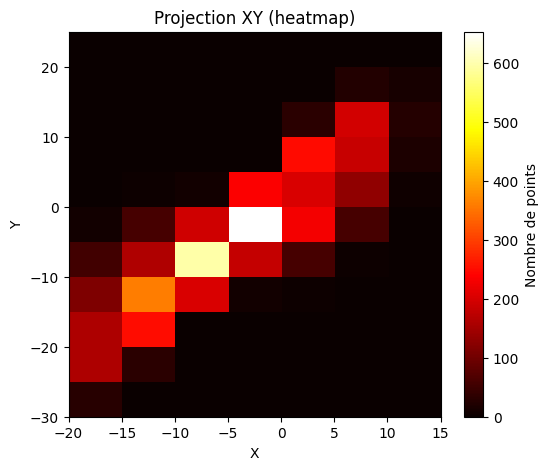

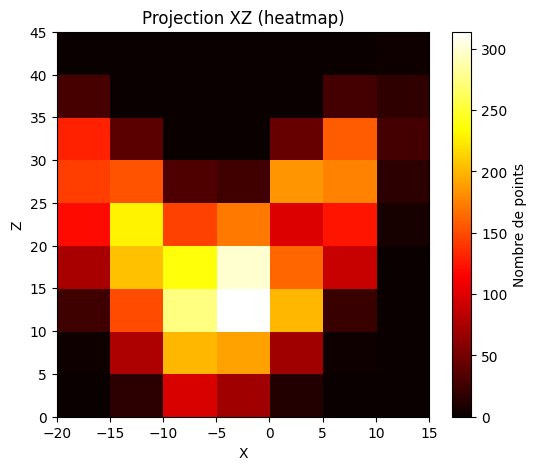

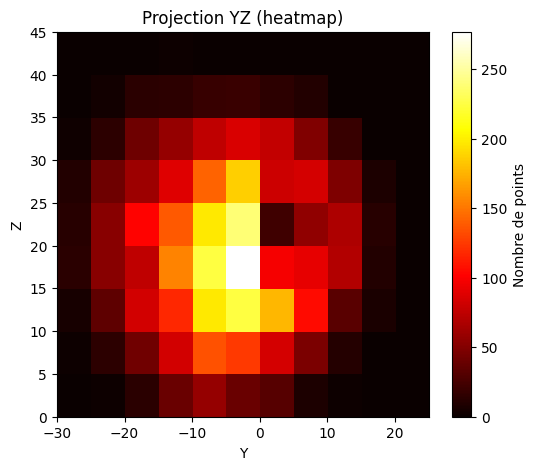

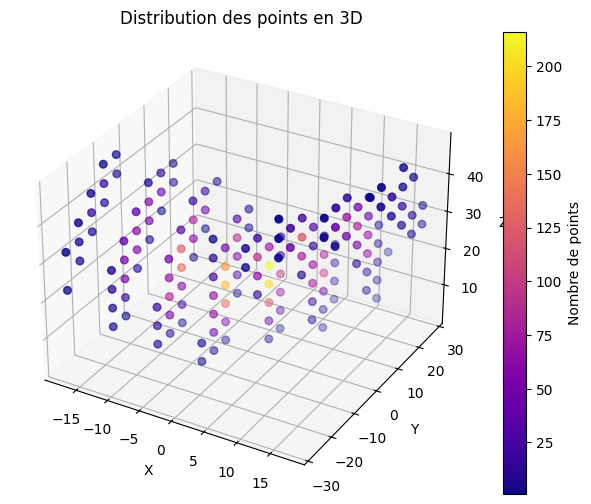

In [3]:

# Parameters 
sigma = 10.0
rho = 28.0
beta = 8.0/3.0
domain = ([-20, 20], [-30, 30], [0, 50])
box_length = 5
state0 = [1.0, 1.0, 1.0] # initial condition
t = np.arange(0.0, 100.0, 0.02) # time vector


# Lorenz model

def Lorenz(state,t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives



states = odeint(Lorenz, state0, t) # vector containing the (x,y,z) positions for each time step

box ={}
box = create_box(domain, box_length)
for i in range(len(states)):
    x = states[i][0]
    y = states[i][1]
    z = states[i][2]
    for b in box.keys():
        if is_in_box(x, y, z, b):
            box[b] += 1

#We verify that we have 5000 points 
sum = 0
for key in box.keys():
    sum += box[key]

plot_2d_heatmaps(box, box_length)
plot_3d_scatter(box)


b) Definition of our distance

In [4]:


def normalize_pdf(hist):
    return hist / np.sum(hist)

def kl_divergence(P, Q):
    P = np.clip(P, 1e-10, 1)  # Évite log(0) et garde P dans une plage valide
    Q = np.clip(Q, 1e-10, 1)
    return np.sum(P * np.log(P / Q))

def bhattacharyya_distance(P, Q):
    bc = np.sum(np.sqrt(P * Q))
    return -np.log(np.clip(bc, 1e-10, 1))






A different type of storing information of the distribution : histogram 

And a general lorenz system

In [5]:
def lorenz(state, t, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


def dict_to_histogram(boxes, domain, box_length):
    # Taille de la grille en 3D
    x_bins = (domain[0][1] - domain[0][0]) // box_length
    y_bins = (domain[1][1] - domain[1][0]) // box_length
    z_bins = (domain[2][1] - domain[2][0]) // box_length

    # Création d'un histogramme vide
    hist = np.zeros((x_bins, y_bins, z_bins))

    # Remplir l'histogramme avec les valeurs du dictionnaire
    for ((x0, x1), (y0, y1), (z0, z1)), count in boxes.items():
        i = int((x0 - domain[0][0]) / box_length)
        j = int((y0 - domain[1][0]) / box_length)
        k = int((z0 - domain[2][0]) / box_length)
        hist[i, j, k] = count  # Mettre le nombre de points

    return hist

def compare_distributions(hist1, hist2):
    """
    Compare two distributions using KL divergence and Bhattacharyya distance.
    """
    hist1_normalized = normalize_pdf(hist1)
    hist2_normalized = normalize_pdf(hist2)

    kl_div = kl_divergence(hist1_normalized, hist2_normalized)
    bhattacharyya_dist = bhattacharyya_distance(hist1_normalized, hist2_normalized)

    return kl_div, bhattacharyya_dist


def create_histogram(domain, box_length , sigma , rho , beta , state0 , t):
    """
    Create a histogram of the Lorenz system in the given domain with the specified box length.
    """
    # Create boxes
    boxes = create_box(domain, box_length)

    # Compute the Lorenz system
    true_states = odeint(lorenz, state0, t, args=(sigma, rho, beta))

    # Compute the number of points in each box
    for i in range(len(states)):
        x = true_states[i][0]
        y = true_states[i][1]
        z = true_states[i][2]
        for b in boxes.keys():
            if is_in_box(x, y, z, b):
                boxes[b] += 1

    # Convert dictionary to histogram
    hist = dict_to_histogram(boxes, domain, box_length)

    return hist



c) 
Visualisation of the impact of the parameter of the system 

In [6]:


# Fonction pour tracer les graphiques
def plot_lorenz(sigma=10.0, rho=28.0, beta=8.0/3.0):
    state0 = [1.0, 1.0, 1.0]  # Conditions initiales
    t = np.linspace(0, 50, 5000)  # Echelle de temps
    states = odeint(lorenz, state0, t, args=(sigma, rho, beta))

    x, y, z = states[:, 0], states[:, 1], states[:, 2]

    # Création des figures
    fig = plt.figure(figsize=(16, 8))
    ax3d = fig.add_subplot(221, projection='3d')
    ax_xy = fig.add_subplot(222)
    ax_xz = fig.add_subplot(223)
    ax_yz = fig.add_subplot(224)

    # Tracé 3D
    ax3d.plot(x, y, z, color='blue', linewidth=0.5)
    ax3d.set_title("Attracteur de Lorenz (3D)")
    ax3d.set_xlabel("X")
    ax3d.set_ylabel("Y")
    ax3d.set_zlabel("Z")

    # Projections 2D
    ax_xy.plot(x, y, color='red', linewidth=0.5)
    ax_xy.set_title("Projection XY")
    ax_xy.set_xlabel("X")
    ax_xy.set_ylabel("Y")

    ax_xz.plot(x, z, color='green', linewidth=0.5)
    ax_xz.set_title("Projection XZ")
    ax_xz.set_xlabel("X")
    ax_xz.set_ylabel("Z")

    ax_yz.plot(y, z, color='purple', linewidth=0.5)
    ax_yz.set_title("Projection YZ")
    ax_yz.set_xlabel("Y")
    ax_yz.set_ylabel("Z")

    plt.show()


We observe the impact of different parameters on the system

In [7]:
interact(plot_lorenz, 
         sigma=FloatSlider(min=0, max=20, step=0.1, value=5),
         rho=FloatSlider(min=0, max=40, step=0.1, value=18),
         beta=FloatSlider(min=0, max=10, step=0.01, value=8))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=20.0), FloatSlider(value=18.0, descripti…

<function __main__.plot_lorenz(sigma=10.0, rho=28.0, beta=2.6666666666666665)>

c) and d) We compute the distance with respectively different parameters and then different initial state

In [8]:
hist1 = create_histogram(domain, box_length, sigma, rho, beta, state0, t)
hist2 = create_histogram(domain, box_length, 5, 18, 8, state0, t)
kl_div, bhattacharyya_dist = compare_distributions(hist1, hist2)
print(f"KL Divergence: {kl_div}")
print(f"Bhattacharyya Distance: {bhattacharyya_dist}")

state1 = [10.0, 10.0, 10.0]
hist1 = create_histogram(domain, box_length, sigma, rho, beta, state0, t)
hist2 = create_histogram(domain, box_length, sigma, rho, beta, state1, t)

kl_div, bhattacharyya_dist = compare_distributions(hist1, hist2)
print(f"KL Divergence: {kl_div}")
print(f"Bhattacharyya Distance: {bhattacharyya_dist}")
print(box)

KL Divergence: 18.126903622427825
Bhattacharyya Distance: 4.509240195534949
KL Divergence: 0.8961158456554495
Bhattacharyya Distance: 0.044788932837424265
{((-20, -15), (-30, -25), (0, 5)): 0, ((-20, -15), (-30, -25), (5, 10)): 0, ((-20, -15), (-30, -25), (10, 15)): 0, ((-20, -15), (-30, -25), (15, 20)): 0, ((-20, -15), (-30, -25), (20, 25)): 1, ((-20, -15), (-30, -25), (25, 30)): 0, ((-20, -15), (-30, -25), (30, 35)): 1, ((-20, -15), (-30, -25), (35, 40)): 0, ((-20, -15), (-30, -25), (40, 45)): 0, ((-20, -15), (-30, -25), (45, 50)): 0, ((-20, -15), (-25, -20), (0, 5)): 0, ((-20, -15), (-25, -20), (5, 10)): 0, ((-20, -15), (-25, -20), (10, 15)): 0, ((-20, -15), (-25, -20), (15, 20)): 0, ((-20, -15), (-25, -20), (20, 25)): 0, ((-20, -15), (-25, -20), (25, 30)): 4, ((-20, -15), (-25, -20), (30, 35)): 10, ((-20, -15), (-25, -20), (35, 40)): 3, ((-20, -15), (-25, -20), (40, 45)): 0, ((-20, -15), (-25, -20), (45, 50)): 0, ((-20, -15), (-20, -15), (0, 5)): 0, ((-20, -15), (-20, -15), (5, 10)

## 1.2 Particle Filter

In [9]:
def multinomial_resampling(weights):
        N = len(weights)
        indices = np.random.choice(N, N, p=weights)
        return indices

def residual_resampling(weights):
    N = len(weights)
    num_copies = np.floor(N * weights).astype(int)
    residuals = weights * N - num_copies
    residuals /= residuals.sum()
    
    indices = np.hstack([
        np.repeat(i, num_copies[i]) for i in range(N)
    ])
    
    num_remaining = N - len(indices)
    if num_remaining > 0:
        resample_indices = np.random.choice(N, num_remaining, p=residuals)
        indices = np.hstack([indices, resample_indices])
    
    return indices

def systematic_resampling(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.uniform()) / N
    cumulative_sum = np.cumsum(weights)
    indices = np.zeros(N, dtype=int)
    j = 0
    for i in range(N):
        while positions[i] > cumulative_sum[j]:
            j += 1
        indices[i] = j
    return indices



def comparaison_of_resampling(N , weights): 
    

    

   
    weights = weights / np.sum(weights)  
    


    indices_multinomial = multinomial_resampling(weights)
    indices_residual = residual_resampling(weights)
    indices_systematic = systematic_resampling(weights)

    def compute_variance(indices, N):
        counts = np.bincount(indices, minlength=N)
        return np.var(counts)

    var_multinomial = compute_variance(indices_multinomial, N)
    var_residual = compute_variance(indices_residual, N)
    var_systematic = compute_variance(indices_systematic, N)

    print(f"Variance Multinomial: {var_multinomial:.4f}")
    print(f"Variance Residual: {var_residual:.4f}")
    print(f"Variance Systematic: {var_systematic:.4f}")

    # Visualisation des résultats
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(indices_multinomial, bins=N, alpha=0.7)
    plt.title("Multinomial Resampling")

    plt.subplot(1, 3, 2)
    plt.hist(indices_residual, bins=N, alpha=0.7)
    plt.title("Residual Resampling")

    plt.subplot(1, 3, 3)
    plt.hist(indices_systematic, bins=N, alpha=0.7)
    plt.title("Systematic Resampling")

    plt.tight_layout()
    plt.show()  


Variance Multinomial: 3.1619
Variance Residual: 3.0555
Variance Systematic: 3.0791


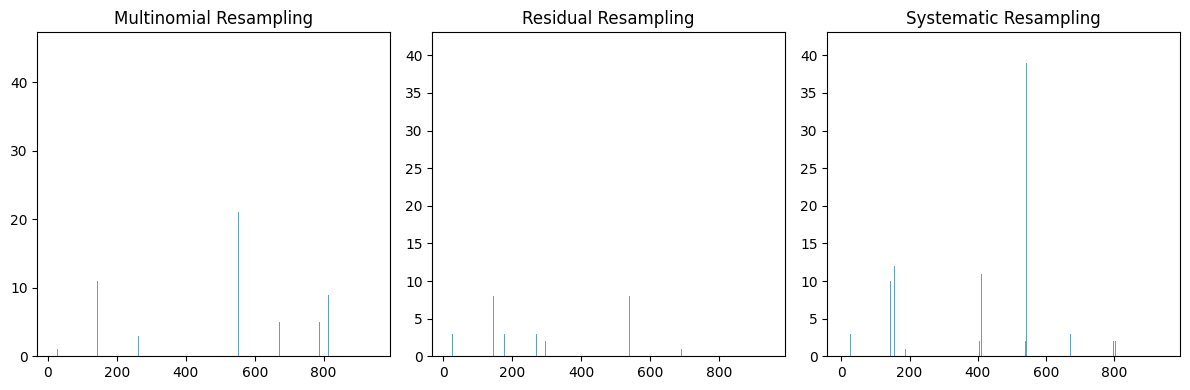

Variance Multinomial: 1.3500
Variance Residual: 0.8404
Variance Systematic: 0.5068


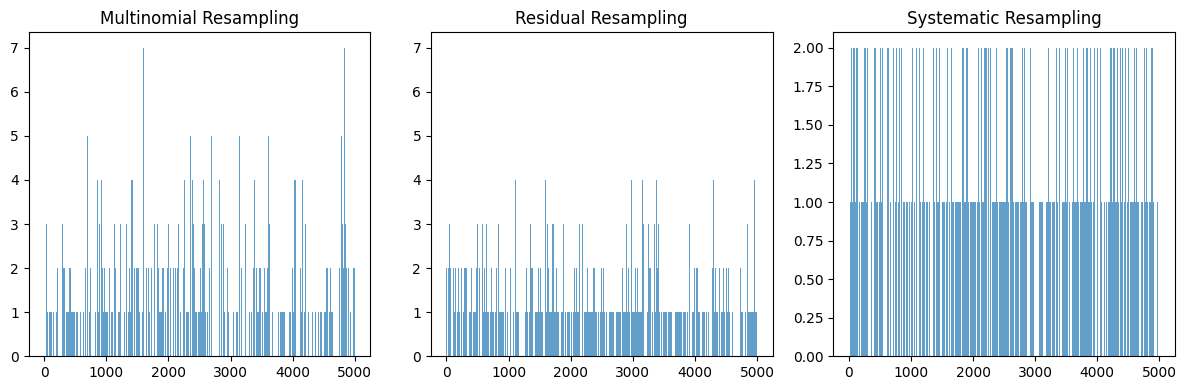

In [10]:
List_box_indices = {}
i = 0
for key in box.keys():
    List_box_indices[key] = i   
    i+=1 

weights = np.array(list(box.values()))
comparaison_of_resampling(5000, weights)
comparaison_of_resampling(5000 , np.random.rand(5000))


In [11]:
import time

def benchmark_resampling(method, alpha, N, iterations=100):
    start_time = time.time()
    for _ in range(iterations):
        method(alpha, N)
    return (time.time() - start_time) / iterations

N = 1000  
alpha = np.random.dirichlet(np.ones(N))  

time_multi = benchmark_resampling(multinomial_resampling, alpha, N)
time_resid = benchmark_resampling(residual_resampling, alpha, N)
time_syst = benchmark_resampling(systematic_resampling, alpha, N)

print(f"Multinomial: {time_multi:.6f} s")
print(f"Residual: {time_resid:.6f} s")
print(f"Systematic: {time_syst:.6f} s")

TypeError: multinomial_resampling() takes 1 positional argument but 2 were given